## Introduction

From the dataset we can see that the training dataset contains 150,000 records, test dataset contains 101,503 records.
There are 10 numeric independent variables and SeriousDlqin2yrs is the Dependent Variable and is binary, 0 or 1.
The Goal of the problem is to Predict the probability of whether a customer will experience financial distress 
( 90 day delinquency or worse) in the next two years. 

## Variable explanantion

SeriousDlqin2yrs : 1/0 whether a person will experience financial distress ( 90 day delinquency or worse) in the next two years

RevolvingUtilizationOfUnsecuredLines : Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits

Age : Age of borrower in years

NumberOfTime30-59DaysPastDueNotWorse : Number of times borrower has been 30-59 days past due but no worse in the last 2 years

DebtRatio : Monthly debt payments, alimony,living costs divided by monthy gross income

MonthlyIncome : Monthly income

NumberOfOpenCreditLinesAndLoans : Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)

NumberOfTimes90DaysLate :Number of times borrower has been 90 days or more past due

NumberRealEstateLoansOrLines :Number of mortgage and real estate loans including home equity lines of credit

NumberOfTime60-89DaysPastDueNotWorse : Number of times borrower has been 60-89 days past due but no worse in the last 2 years

NumberOfDependents :Number of dependents in family excluding themselves (spouse, children etc.)

### Import library

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance


### Import dataset 

Dataset downloaded from [https://www.kaggle.com/competitions/GiveMeSomeCredit/data]

In [2]:
train_df = pd.read_csv("cs-training.csv")
test_df = pd.read_csv("cs-test.csv")
train_df = train_df.drop('Unnamed: 0', axis=1)
test_df = test_df.drop('Unnamed: 0', axis=1)


In [3]:
train_df.head(5)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## Exploring dataset

### Label Distribution

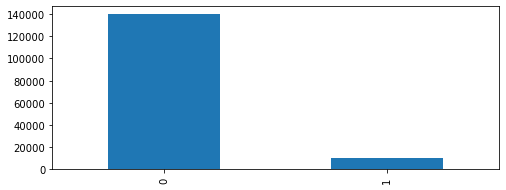

In [4]:
plt.figure(figsize=(8,3))
train_df['SeriousDlqin2yrs'].value_counts().plot(kind='bar')
plt.show()

We see the class is imbalanced.

### Correlation Matrix

<AxesSubplot:>

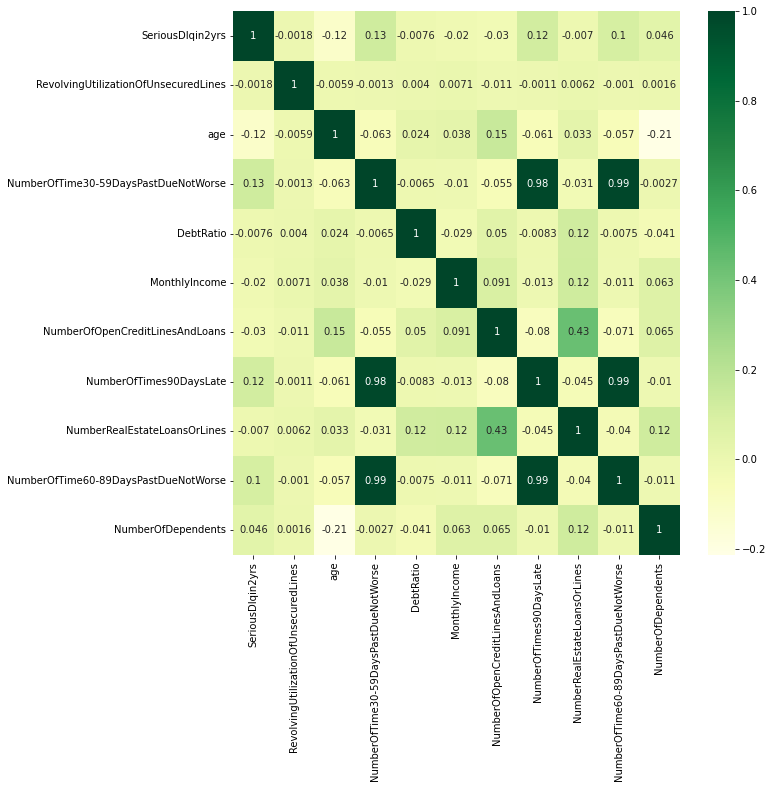

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(train_df.corr(), annot=True, cmap="YlGn", ax=ax)

From the correlation matrix we can see thatNumberOfTimes90DaysLate, NumberOfTime30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse have a strong correlation.

### Based on age and number of days late

Plotting graph for column NumberOfTimes90DaysLate, NumberOfTime30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse by grouping age from 0 to 25, 25 to 50, 50 to 100. 

In [6]:
cuts =  pd.cut(train_df['age'], [0,25,50, 100])
 
grouped_by_age_90_days_late = (train_df.groupby([cuts])
   .NumberOfTimes90DaysLate.sum()
   .reset_index(name='NumberOfTimes90DaysLate')
)
grouped_by_age_90_days_late.columns = ['age bucket', 'sum of NumberOfTimes90DaysLate']


In [7]:
def group_age(days_late):
    grouped_by_days_late = (train_df.groupby([cuts])
       [days_late].sum()
       .reset_index(name=days_late)
    )
    grouped_by_days_late.columns = ['age bucket', f'sum_of_{days_late}']  
    return grouped_by_days_late


In [8]:
df_NumberOfTimes90DaysLate = group_age('NumberOfTimes90DaysLate')

df_NumberOfTime30_59DaysPastDueNotWorse = group_age('NumberOfTime30-59DaysPastDueNotWorse')

df_NumberOfTime60_89DaysPastDueNotWorse = group_age('NumberOfTime60-89DaysPastDueNotWorse')


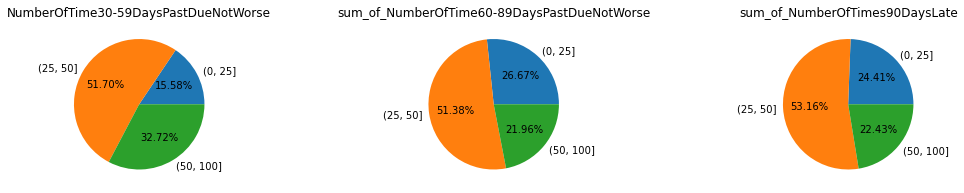

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18,3))

axes[0].pie(x=df_NumberOfTime30_59DaysPastDueNotWorse["sum_of_NumberOfTime30-59DaysPastDueNotWorse"], labels = df_NumberOfTime60_89DaysPastDueNotWorse["age bucket"],autopct='%1.2f%%')
axes[0].set_title("NumberOfTime30-59DaysPastDueNotWorse")

axes[1].pie(x=df_NumberOfTime60_89DaysPastDueNotWorse["sum_of_NumberOfTime60-89DaysPastDueNotWorse"], labels = df_NumberOfTime60_89DaysPastDueNotWorse["age bucket"],autopct='%1.2f%%')
axes[1].set_title("sum_of_NumberOfTime60-89DaysPastDueNotWorse")

axes[2].pie(x=df_NumberOfTimes90DaysLate["sum_of_NumberOfTimes90DaysLate"], labels = df_NumberOfTime60_89DaysPastDueNotWorse["age bucket"],autopct='%1.2f%%')
axes[2].set_title("sum_of_NumberOfTimes90DaysLate")

plt.show()

From the pie chart we can see that number of times borrower has been 30 to 59 days or 60 to 89 days or 90 days or more past due the age group from 25-50 has the highest percentage. For age group 0 to 25 the number of time the borrower has been 30 to 59 days past due is 15.58% which is less compared to the 60 to 89 days and 90 days or more. It is clear from the graph that the age group from 25 to 50 has the highest percentage of borrowers who has past due.


### Relation between Monthly Income and NumberRealEstateLoansOrLines based on SeriousDlqin2yrs

In [10]:
cuts =  pd.cut(train_df['MonthlyIncome'], [0,5000,10000,50000,100000,500000,1000000,5000000])


grouped_by_monthly_income = (train_df.groupby(['SeriousDlqin2yrs', cuts])
   .NumberRealEstateLoansOrLines.sum()
   .reset_index(name='NumberRealEstateLoansOrLines')
)
grouped_by_monthly_income.columns = ['SeriousDlqin2yrs', 'MonthlyIncome','sum of NumberRealEstateLoansOrLines']
grouped_by_monthly_income

,SeriousDlqin2yrs,MonthlyIncome,sum of NumberRealEstateLoansOrLines
0,0,"(0, 5000]",33809
1,0,"(5000, 10000]",52686
2,0,"(10000, 50000]",29908
3,0,"(50000, 100000]",493
4,0,"(100000, 500000]",102
5,0,"(500000, 1000000]",7
6,0,"(1000000, 5000000]",8
7,1,"(0, 5000]",3077
8,1,"(5000, 10000]",3645
9,1,"(10000, 50000]",1866


In [11]:
grouped_by_monthly_income[grouped_by_monthly_income['SeriousDlqin2yrs'] == 0]['sum of NumberRealEstateLoansOrLines']

grouped_by_monthly_income['MonthlyIncome'] = grouped_by_monthly_income['MonthlyIncome'].apply(lambda x: f'{x}')



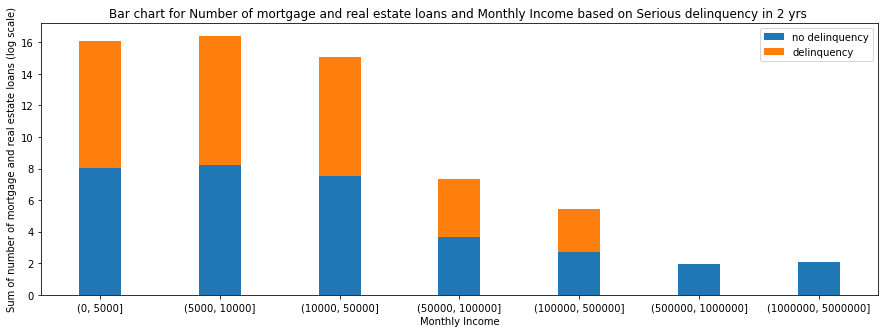

In [12]:
import matplotlib.pyplot as plt
from math import log

labels = list(grouped_by_monthly_income['MonthlyIncome'].unique())
no_delinquency = list(grouped_by_monthly_income[grouped_by_monthly_income['SeriousDlqin2yrs'] == 0]['sum of NumberRealEstateLoansOrLines'])
no_delinquency = [ log(i) for i in no_delinquency]
delinquency = list(grouped_by_monthly_income[grouped_by_monthly_income['SeriousDlqin2yrs'] == 1]['sum of NumberRealEstateLoansOrLines'])
delinquency = [ log(i) if i else i for i in delinquency  ]

width = 0.35
fig, ax = plt.subplots(figsize=(15,5))


ax.bar(labels, no_delinquency, width,   label='no delinquency')
ax.bar(labels, delinquency, width, bottom=delinquency, label='delinquency')

ax.set_xlabel('Monthly Income')
ax.set_ylabel('Sum of number of mortgage and real estate loans (log scale)')
ax.set_title('Bar chart for Number of mortgage and real estate loans and Monthly Income based on Serious delinquency in 2 yrs ')
ax.legend()

plt.show()

In the above bar chart the value on y axis is sum of NumberRealEstateLoansOrLines which has been transformed to logarithmic scale. This has been done because when the values we are plotting span a large range for monthly income (0 to 5000) to (10000, 50000), using a logarithmic scale can help us to compress the scale and make the data easier to read. Logarithmic scales is useful when working with data that has a skewed distribution, as they help to show more detail in the lower end of the scale for income range between (100000, 500000) to (1000000,5000000).
* From the graph we can see that person in income range between (5000 to 10000) has experienced high deliquency with the sum of 52686 as well as no deliquency with the sum of 3645 in past 2 years, due to number of mortgage and real estate loans including home equity lines of credit. 
* The highest income range person from (1000000 to 5000000) has experienced no deliquency due mortgage and real estate loans.	
* The graph makes it clear that people with low income levels have mortgage and real estate loans and are frequently default by 90 days or more.




### Relation between Age, Monthly Income and Debt ratio

In [13]:
cuts =  pd.cut(train_df['age'], [0, 25,30,35,40,45,50,55, 60])


grouped_by_monthly_income = (train_df.groupby([cuts])
   .MonthlyIncome.mean()
   .reset_index(name='monthly income')
)
# grouped_by_monthly_income.columns = ['SeriousDlqin2yrs', 'MonthlyIncome','sum of NumberRealEstateLoansOrLines']
grouped_by_monthly_income

,age,monthly income
0,"(0, 25]",1992.730087
1,"(25, 30]",3673.554835
2,"(30, 35]",5180.510545
3,"(35, 40]",6188.330111
4,"(40, 45]",7243.002241
5,"(45, 50]",7437.940519
6,"(50, 55]",7867.948751
7,"(55, 60]",7627.215218


In [14]:
grouped_by_age = train_df.groupby(['SeriousDlqin2yrs', cuts])['MonthlyIncome', 'DebtRatio'].mean().reset_index()


/var/folders/6r/8n0kzrvd2f72hlgxv5_vbj7r0000gn/T/ipykernel_17658/2826910127.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_by_age = train_df.groupby(['SeriousDlqin2yrs', cuts])['MonthlyIncome', 'DebtRatio'].mean().reset_index()


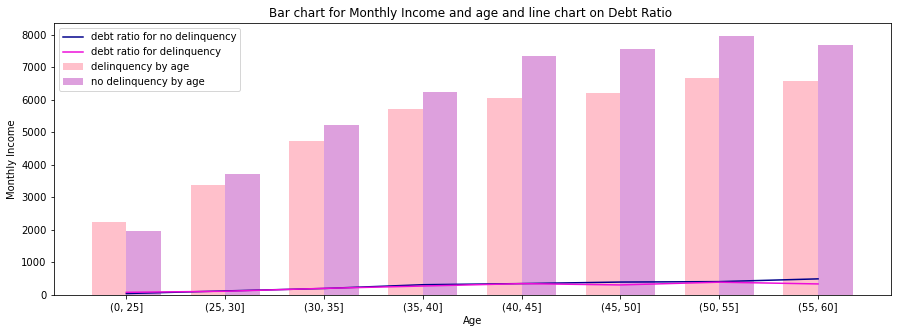

In [15]:
import matplotlib.pyplot as plt
from math import log

labels = list(grouped_by_age['age'].unique())
labels = [f'{label}' for label in labels]

no_delinquency_age = list(grouped_by_age[grouped_by_age['SeriousDlqin2yrs'] == 0]['MonthlyIncome'])
delinquency_age = list(grouped_by_age[grouped_by_age['SeriousDlqin2yrs'] == 1]['MonthlyIncome'])

no_delinquency_debt_ratio = list(grouped_by_age[grouped_by_age['SeriousDlqin2yrs'] == 0]['DebtRatio'])
delinquency_debt_ratio = list(grouped_by_age[grouped_by_age['SeriousDlqin2yrs'] == 1]['DebtRatio'])

width = 0.35
fig, ax = plt.subplots(figsize=(15,5))

x = np.arange(len(labels))  


ax.bar(x - width/2, delinquency_age, width,   label='delinquency by age', color="#ffc0cb")
ax.bar(x + width/2, no_delinquency_age, width,  label='no delinquency by age', color="#dda0dd")

ax.plot(labels, no_delinquency_debt_ratio,  color="#00008b", label='debt ratio for no delinquency')
ax.plot(labels, delinquency_debt_ratio, color="#ed0dd9", label='debt ratio for delinquency')

ax.set_xlabel('Age')
ax.set_ylabel('Monthly Income')
ax.set_title('Bar chart for Monthly Income and age and line chart on Debt Ratio ')
ax.legend()

plt.show()

Ages 0 to 25, 25 to 30, 30 to 35, 35 to 40, 40 to 45, 45 to 50, 50 to 55, and 55 to 60 are grouped together on the x axis of the above bar graph. The graph shows that those who are younger have low incomes, and as they get older, their incomes rise as well. We can see that those between the ages of 50 and 55 have the highest incomes.
* In comparison to other age groups, the delinquency rate for those between the ages of 0 and 25 is high, while the rate for those without a delinquency is low. We can observe that no delinquency has gradually increased and decreased as income and age have increased.
* The debt ratio is displayed in the graph's line chart. The debt-to-income ratio is slowly rising as people's ages rise. No delinquency and delinquency have almost the same debt ratios.


### Outliers

Outliers are data that stand out from the rest of the data in a significant way. They can have a large effect on statistical analyses and modelling. By eliminating outliers, statistical models' precision and dependability can be increased.  Outliers may contain important information, therefore carefully evaluating the advantages and disadvantages of keeping them is crucial because doing so could induce bias.

### Checking outliers for NumberOfTimes90DaysLate, NumberOfTime30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse

Text(0.5, 1.0, 'NumberOfTime60-89DaysPastDueNotWorse')

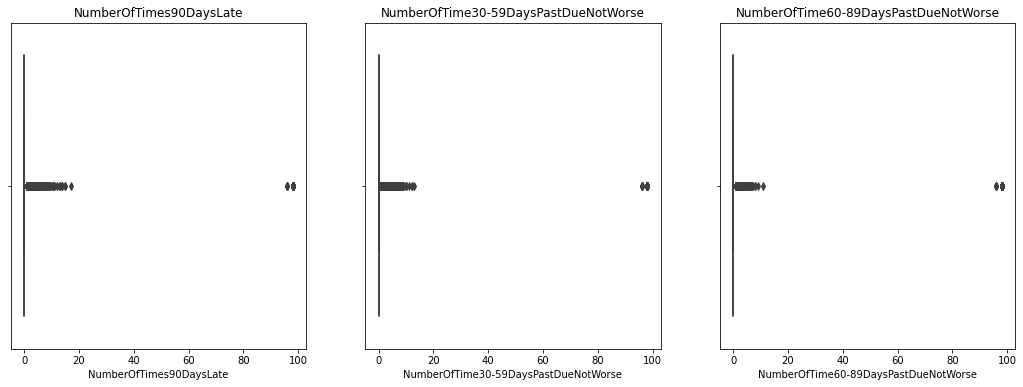

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))
sns.boxplot(x=train_df['NumberOfTimes90DaysLate'],ax = axes[0])
axes[0].set_title('NumberOfTimes90DaysLate')
sns.boxplot(x=train_df['NumberOfTime30-59DaysPastDueNotWorse'],ax = axes[1])
axes[1].set_title('NumberOfTime30-59DaysPastDueNotWorse')
sns.boxplot(x=train_df['NumberOfTime60-89DaysPastDueNotWorse'],ax = axes[2])
axes[2].set_title('NumberOfTime60-89DaysPastDueNotWorse')

From the box plot we can see there are outliers present in the dataset for days beyond 90 days. Hence we will remove the outliers. 

In [17]:
lower = 0
upper = 90

def remove_outliers(data,column):
    outliers_removed = data[data[column].between(lower, upper)]
    return outliers_removed

In [18]:
outlier_removed_train_df = remove_outliers(train_df,'NumberOfTimes90DaysLate')
outlier_removed_train_df = remove_outliers(outlier_removed_train_df,'NumberOfTime30-59DaysPastDueNotWorse')
outlier_removed_train_df = remove_outliers(outlier_removed_train_df,'NumberOfTime60-89DaysPastDueNotWorse')

In [19]:
train_df = outlier_removed_train_df

### Boxplot after removing outliers for NumberOfTimes90DaysLate, NumberOfTime30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse

Text(0.5, 1.0, 'NumberOfTime60-89DaysPastDueNotWorse')

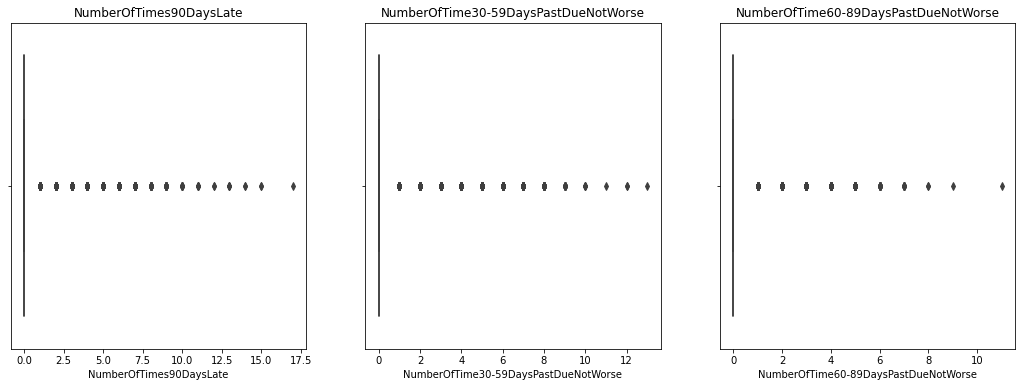

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))
sns.boxplot(x=train_df['NumberOfTimes90DaysLate'],ax = axes[0])
axes[0].set_title('NumberOfTimes90DaysLate')
sns.boxplot(x=train_df['NumberOfTime30-59DaysPastDueNotWorse'],ax = axes[1])
axes[1].set_title('NumberOfTime30-59DaysPastDueNotWorse')
sns.boxplot(x=train_df['NumberOfTime60-89DaysPastDueNotWorse'],ax = axes[2])
axes[2].set_title('NumberOfTime60-89DaysPastDueNotWorse')

### Checking outliers for RevolvingUtilizationOfUnsecuredLines

Since the Credit Utilization is anticipated to fall within the range (0-1) , the RevolvingUtilizationOfUnsecuredLines column has been verified. However, we observe values that are outside of this range. Even yet, borrowers occasionally go above their credit limit. 2% of the dataset is made up of numbers between 1 and 10. Values greater than 10 are quite large and represent less than 0.5% of our data; they would be removed to avoid having an impact on our model.

<AxesSubplot:>

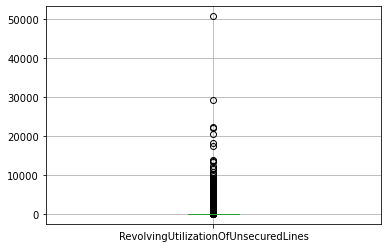

In [21]:
train_df.boxplot(column=['RevolvingUtilizationOfUnsecuredLines'])  


Below box plot showing credit utilization less than 10. 

<AxesSubplot:>

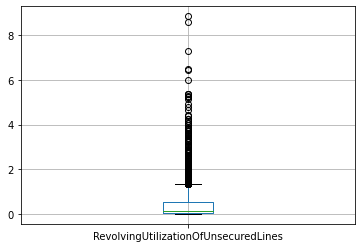

In [22]:
temp = train_df[train_df['RevolvingUtilizationOfUnsecuredLines'] <= 10]
temp.boxplot(column=['RevolvingUtilizationOfUnsecuredLines'])  

In [23]:
tmp = train_df[train_df['SeriousDlqin2yrs'] == 1]
tmp[tmp['RevolvingUtilizationOfUnsecuredLines'] < 10]['RevolvingUtilizationOfUnsecuredLines'].mean()

0.7042918686082079

In [24]:
tmp = train_df[train_df['SeriousDlqin2yrs'] == 0]
tmp[tmp['RevolvingUtilizationOfUnsecuredLines'] < 10]['RevolvingUtilizationOfUnsecuredLines'].mean()

0.2945055021541797

When we calculate the average credit utilisation for people in financial difficulty, we also notice that the number is high (70.42%), while the value for those who are not in financial difficulty is low (29.45%). And it is true that people who use their credit cards heavily are more likely to experience financial hardship.

### Removing outliers for RevolvingUtilizationOfUnsecuredLines

In [25]:
train_df = train_df[train_df['RevolvingUtilizationOfUnsecuredLines'] <= 10]

## Missing Values

A dataset should be checked for missing values because they can affect how accurately statistical analyses and modelling are performed. Missing values might produce skewed or false findings if they are not properly accounted for.

### Checking for missing values in dataset

In [26]:
pd.DataFrame({'count':train_df.isnull().sum().values, 'ratio': train_df.isnull().mean() * 100})


,count,ratio
SeriousDlqin2yrs,0,0.000000
RevolvingUtilizationOfUnsecuredLines,0,0.000000
age,0,0.000000
NumberOfTime30-59DaysPastDueNotWorse,0,0.000000
DebtRatio,0,0.000000
MonthlyIncome,29542,19.761857
NumberOfOpenCreditLinesAndLoans,0,0.000000
NumberOfTimes90DaysLate,0,0.000000
NumberRealEstateLoansOrLines,0,0.000000
NumberOfTime60-89DaysPastDueNotWorse,0,0.000000


In [27]:
train_df[train_df['NumberOfDependents'].isnull()][['MonthlyIncome', 'DebtRatio']].describe()


,MonthlyIncome,DebtRatio
count,0.0,3880.000000
mean,NaN,1093.029381
std,NaN,4208.981558
min,NaN,0.000000
25%,NaN,22.000000
50%,NaN,373.000000
75%,NaN,1571.000000
max,NaN,220516.000000


There are only two features with missing values:
Monthly Income with the count of 29542 and Number of Dependents with count of 3880 in training dataset.

### Handling missing values

* Handling Missing Monthly Income 

The monthly income of borrowers with high debt ratios, as summarised by statistics, is zero. This could imply that borrowers with missing monthly income purposefully left the column blank because they are low-wage earners. 

* Handling Missing Number of Dependents

Records with missing MonthlyIncome also had records with missing Number of Dependents. This demonstrates that the same group of borrowers who left the Monthly Income field empty also did the same with the Dependents field. They don't have any dependents, according to the statistics for borrowers who have missing monthly income. It makes sense that borrowers in this category—those with little to no income—do not have any dependents.

Machine learning's MinMaxScaler is a preprocessing technique that changes a dataset's features by scaling the data so that it has a minimum value of 0 and a maximum value of 1. MinMaxScaler is used to normalize the features of a dataset .The performance of the model can be enhanced in these circumstances by using MinMaxScaler to scale all of the features to the same value.

KNNImputer is an imputation method for filling in missing values in a dataset using the k-nearest neighbors algorithm. It works by finding the k-nearest neighbors of each sample with missing values, and then using the values of those neighbors to impute the missing values.

In [28]:
scaler = MinMaxScaler()
train_df_normalize = pd.DataFrame(scaler.fit_transform(train_df), columns = train_df.columns)
train_df_normalize.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1.0,0.086550,0.412844,0.153846,2.435759e-06,0.003031,0.224138,0.000000,0.111111,0.0,0.10
1,0.0,0.108130,0.366972,0.000000,3.696982e-07,0.000864,0.068966,0.000000,0.000000,0.0,0.05
2,0.0,0.074355,0.348624,0.076923,2.581822e-07,0.001011,0.034483,0.058824,0.000000,0.0,0.00
3,0.0,0.026414,0.275229,0.000000,1.093528e-07,0.001097,0.086207,0.000000,0.000000,0.0,0.00
4,0.0,0.102491,0.449541,0.076923,7.560939e-08,0.021134,0.120690,0.000000,0.018519,0.0,0.00


In [29]:
imputer = KNNImputer()
imputer.fit(train_df_normalize)
train_df_no_null_values = imputer.transform(train_df_normalize)


In [30]:
train_data = pd.DataFrame(train_df_no_null_values)
train_data.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
dtype: int64

In [31]:
x = train_df.drop("SeriousDlqin2yrs", axis=1)
y = train_df["SeriousDlqin2yrs"]
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149490 entries, 0 to 149999
Data columns (total 10 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   RevolvingUtilizationOfUnsecuredLines  149490 non-null  float64
 1   age                                   149490 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  149490 non-null  int64  
 3   DebtRatio                             149490 non-null  float64
 4   MonthlyIncome                         119948 non-null  float64
 5   NumberOfOpenCreditLinesAndLoans       149490 non-null  int64  
 6   NumberOfTimes90DaysLate               149490 non-null  int64  
 7   NumberRealEstateLoansOrLines          149490 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  149490 non-null  int64  
 9   NumberOfDependents                    145610 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 12.5 MB


### Splitting dataset to training and validation set

An essential step in creating and assessing machine learning models is dividing a dataset into a training set and a validation set. The validation set is used to assess the model's performance after it has been trained using the training set. The model may have overfitted to the training data if it performs well on the training set but badly on the validation set. On the other side, the model may be underfitting and failing to recognise the underlying patterns in the data if it performs badly on both the training and validation sets. We can identify and fix these problems by dividing the dataset into distinct training and validation sets.

In [32]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=0)


### XGBClassifier
For machine learning, XGBoost (eXtreme Gradient Boosting) is a well-liked and effective gradient boosting method. The gradient boosting approach is implemented by the class XGBClassifier in the XGBoost library for classification problems.
Gradient boosting is a supervised learning technique that involves sequentially training a number of weak learners, or simple models, with the goal of correcting the flaws of the preceding model. Decision trees are used as the weak learners in the gradient boosting process by the XGBClassifier class of XGBoost. It contains a variety of hyperparameters that can be adjusted to enhance the model's functionality.


In [33]:
from xgboost import XGBClassifier

gs = XGBClassifier()
parameters = {'n_estimators':[1018],
              'colsample_bytree':[0.5],
              'subsample': [0.8], 
              'max_depth': [6],
              'min_child_weight': [3],
              'learning_rate': [0.01]
             }



### GridSearchCV
A scikit-learn method called GridSearchCV conducts an exhaustive search for an estimator over a given parameter grid. It is frequently used to adjust a machine learning model's hyperparameters in order to enhance performance.

In [34]:
from sklearn.model_selection import GridSearchCV

xgb_grid = GridSearchCV(gs,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

### Model fit

In [35]:
lgbm_fit = xgb_grid.fit(x_train, y_train)
print(lgbm_fit.best_score_)
print(lgbm_fit.best_params_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
0.9371959989373844
{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 1018, 'subsample': 0.8}


In [36]:
final = lgbm_fit.fit(x_train, y_train)
final

Fitting 2 folds for each of 1 candidates, totalling 2 fits


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                   

### AUC score
A binary classifier's performance is measured by the AUC (Area Under the Curve) score. It shows the likelihood that a randomly selected positive case would be ranked higher than a randomly selected negative instance by the classifier. A classifier that performs no better than random guessing has an AUC value of 0.5, whereas a perfect classifier has an AUC score of 1.0. 
A graphical plot called the ROC curve (Receiver Operating Characteristic curve) shows how a binary classifier system performs as the discrimination threshold is changed. Plotting the true positive rate (TPR) versus the false positive rate (FPR) at different categorization criteria results in the curve. A classifier is considered to be flawless if it produces a ROC curve that passes through the upper left corner of the plot and has a true positive rate of 100% and a false positive rate of 0%. A classifier with a true positive rate and false positive rate that are similar is considered to be a poor classifier and produces a ROC curve that is near to the diagonal line.

0.8633856365997313


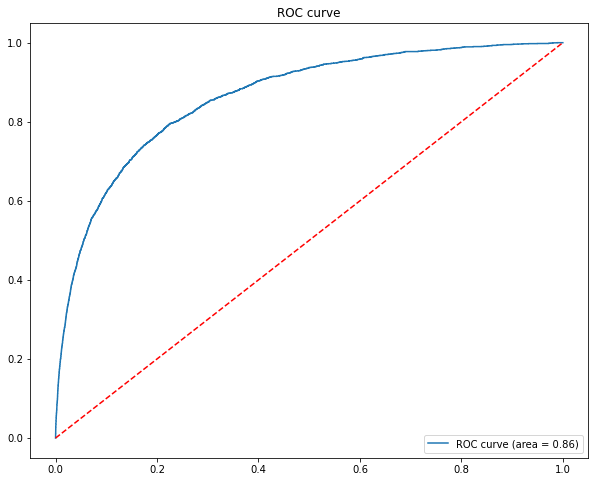

In [37]:
from sklearn.metrics import auc
y_pred = final.predict_proba(x_val)[:,1]

def plot_roc(y_test, y_predict):
    fpr, tpr, _ = roc_curve(y_test, y_predict)
    roc_auc = auc(fpr,tpr)
    print(roc_auc)
    plt.figure(figsize=(10,8))
    plt.title("ROC curve")
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0,1], [0,1],'r--')
    plt.legend(loc="lower right")
plot_roc(y_val, y_pred)

From our result the AUC score is 0.8633.

### Accuracy

In [38]:
print("training accuracy: {:.2f}".format(lgbm_fit.score(x_train, y_train) * 100))
print("validation accuracy: {:.2f}".format(lgbm_fit.score(x_val, y_val) * 100))

training accuracy: 94.35
validation accuracy: 93.86


In [39]:
x = test_df.drop(["SeriousDlqin2yrs"], axis=1)
y = lgbm_fit.predict_proba(x)[:, 1]
ids = x.index.values

In [40]:
# ids = np.arange(1,len(y)+1)
# submission = pd.DataFrame( {'Id': ids, 'Probability': y})
# submission.to_csv("/kaggle/working/submission.csv", index=False)

### Finding best features using XGBClassifier

In [41]:
final.best_estimator_.feature_importances_

array([0.08683096, 0.02288735, 0.1763041 , 0.01989217, 0.01923904,
       0.02182845, 0.41250953, 0.02358558, 0.2016375 , 0.01528533],
      dtype=float32)

<BarContainer object of 10 artists>

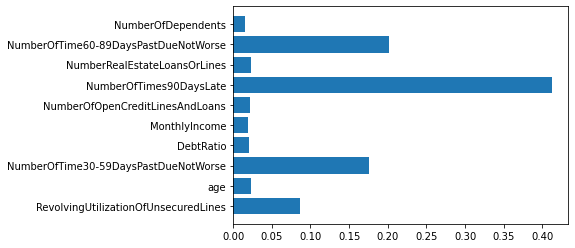

In [42]:
plt.barh(x_train.columns, final.best_estimator_.feature_importances_)


From the bar graph we can see that highest score is for feature NumberOfTimes90DaysLate followed by NumberOfTime60-89DaysPastDueNotWorse, NumberOfTime30-59DaysPastDueNotWorse and RevolvingUtilizationOfUnsecuredLines.